In [1]:
from Mira220 import Mira220
from measurements import Measurement
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
from tqdm.notebook import tqdm

In [2]:
# Initialise sensor
pd.options.display.float_format = "{:.3f}".format
sensor = Mira220(dev_port=0, bpp=12, fps=30, roi_w=1600, roi_h=1400, lanes=2)
sensor.set_analog_gain(1)
m = Measurement('noise', sensor, show_plots=True, roi_process_w=1600//5, roi_process_h=1400//5)

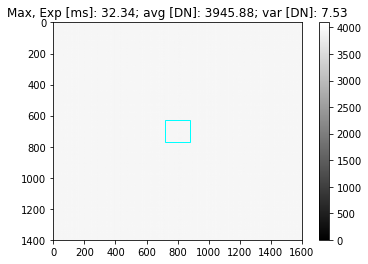

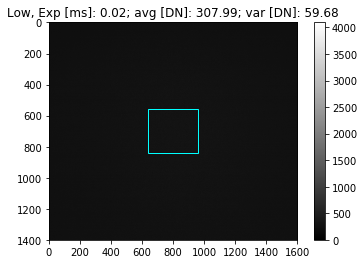

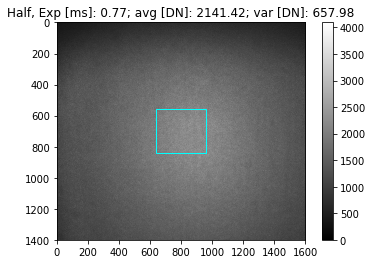

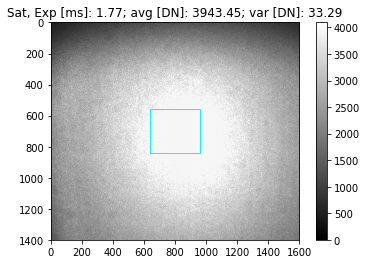

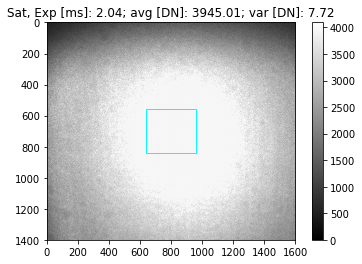

Saturation exposure time: 2.037

Acquiring grey image series


  0%|          | 0/45 [00:00<?, ?it/s]

,Average [DN],Variance [DN]
Exposure time light [ms],,
0.008,279.913,48.091
0.047,366.579,64.571
0.094,464.256,82.221
0.141,562.057,108.588
0.188,662.820,145.588
0.234,765.080,191.887
0.281,869.872,237.842
0.320,957.006,272.604
0.367,1062.744,308.072



Acquiring dark image series
Cover the sensor. Press enter to continue...


,Average [DN],Variance [DN]
Exposure time dark [ms],,
0.008,230.771,11.524


Processing images...


In [3]:
# Parameters
nb_imgs = 50
exp_steps = 45

# Enable illumination
if m.illum_internal:
    m.config_illum_trigger_from_exp(sensor, 1e3 / sensor.fps - 5)
    currents = [1010]
    for current in currents:
        try:
            sensor.set_illuminator(True, current=current, timeout=1100)
            exp_max = m.find_sat_exposure_time(sensor)
            break
        except Exception:
            if current == 1010:
                raise Exception(f'Error: Cannot saturation. Please check your illumination, take a smaller processing ROI or bring your sensor closer to the reflection surface.')
            else:
                print('Increasing the illumination current...')
    m.config_illum_trigger_from_exp(sensor, exp_max)
else:
    input('Turn on your illumination. Press enter to continue...')
    exp_max = m.find_sat_exposure_time(sensor)
print(f'Saturation exposure time: {exp_max:.3f}\n')

# Set exposure time
exposure_times = np.linspace(0, exp_max, exp_steps) # ms
exposure_times[0] = sensor.lines_to_time(1)

# Acquire light series
print('Acquiring grey image series')
avg_light = []
var_light = []
img_avg_light = []
img_var_light = []
exposure_times_actual = []
pbar = tqdm(exposure_times)
for exposure_time in pbar:
    sensor.set_exposure(exposure_time)
    exposure_times_actual.append(sensor.get_exposure())
    time.sleep(1)
    imgs = sensor.grab_imgs(nb_imgs, m.save_imgs, os.path.join(os.getcwd(), 'ptc_light/'))
    imgs = m.apply_process_roi(imgs)
    img_avg = np.average(imgs, axis=0)
    img_var = np.var(imgs, axis=0, ddof=1)    
    img_avg_light.append(img_avg)
    img_var_light.append(img_var)
    avg_light.append(np.average(img_avg))
    var_light.append(np.average(img_var))
    pbar.set_postfix_str(f'exposure [ms]: {exposure_times_actual[-1]:.3f}, avg [DN]: {avg_light[-1]:.3f}, var [DN]: {var_light[-1]:.3f}')
df_progress = pd.DataFrame(list(zip(exposure_times_actual, avg_light, var_light)), 
                           columns=['Exposure time light [ms]', 'Average [DN]', 'Variance [DN]'])
df_progress.set_index('Exposure time light [ms]', inplace=True)
display(df_progress)

# Acquire dark series (only 1 implemented)
print('\nAcquiring dark image series')
if m.illum_internal:
    sensor.set_illuminator(False)
    input('Cover the sensor. Press enter to continue...')
else:
    input('Turn off your illumination and cover the sensor. Press enter to continue...')
exposure_time_dark = exposure_times[0]
sensor.set_exposure(exposure_time_dark)
imgs = sensor.grab_imgs(nb_imgs, m.save_imgs, os.path.join(os.getcwd(), 'ptc_dark/'))
imgs = m.apply_process_roi(imgs)
img_avg_dark = np.average(imgs, axis=0)
img_var_dark = np.var(imgs, axis=0, ddof=1)
del imgs
avg_dark = np.average(img_avg_dark)
var_dark = np.average(img_var_dark)
df_progress = pd.DataFrame(list(zip([exposure_time_dark], [avg_dark], [var_dark])), 
                           columns=['Exposure time dark [ms]', 'Average [DN]', 'Variance [DN]'])
df_progress.set_index('Exposure time dark [ms]', inplace=True)
display(df_progress)

# Process data
print('Processing images...')
avg_light = np.array(avg_light)
var_light = np.array(var_light)


conversion gain e$^-$/DN: 3.055
offset: 11.89482978540154


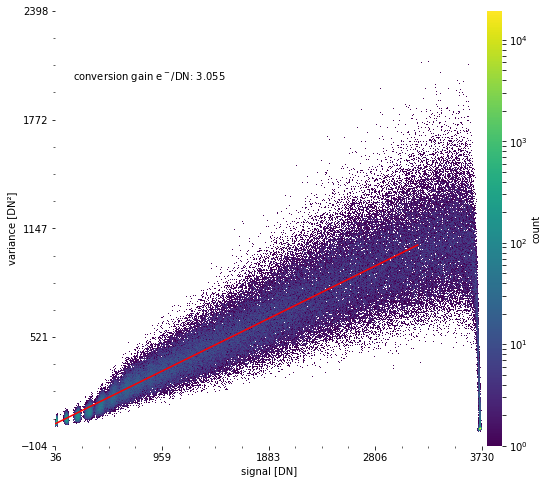

In [21]:
import matplotlib.colors as mcolors
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

d = (img_avg_light - img_avg_dark).flatten()
dv = (img_var_light - img_var_dark).flatten()

bins = 1024*2
dvmin, dvmax = max(-10,dv.min()), min(50, dv.max())
dmin, dmax = 0, d.max()
# H, d_edges, dv_edges  = np.histogram2d(d,dv,bins=bins, normed=False, range=[[dmin, dmax],[dvmin, dvmax]])
H, d_edges, dv_edges  = np.histogram2d(d,dv,bins=bins, normed=False)
H = H.astype(np.uint32)


# find center values for X and Y
_yvals = dv_edges[0:-1] + 0.5*(dv_edges[1]-dv_edges[0])
_xvals = d_edges[0:-1]  + 0.5*(d_edges[1]-d_edges[0])


# cutoff for fit, should be based on maximum variance points (not simple), just number now
xcutoff_factor = 0.85
xcutoff = int(_xvals.shape[0] * xcutoff_factor)

# tile, replicate Y values for fit
yvals = np.tile(_yvals,_xvals[0:xcutoff].shape)


# repeat, replicate X values for fit (tile or repeat depends on which axis the data is on)
# result is 1D
xvals = np.repeat(_xvals[0:xcutoff],_yvals.shape)


# use histogram as weight for fit, cut on X values
weights = H[0:xcutoff,:].ravel()


# FIT

#filter out  weight=0 points; strictly not needed, but seems to prevent convergence errors
slope, offset = np.polyfit(xvals[weights !=0],yvals[weights !=0],1,w=weights[weights !=0])

print('conversion gain e$^-$/DN: {0:.3f}'.format(1/slope))
print(f'offset: {offset}')

# y = offset + slope * x
# minimum x value that participated in the fit
minxfit = xvals[weights !=0].min()
# maximum is _xvals[xcutoff]
# the fit line goes from (X,Y): (minxfit, offset+minxfit*slope) to (_xvals[xcutoff], offset+_xvals[xcutoff]*slope)

plt.figure(figsize=(8, 8))

plt.imshow(H.T, cmap='viridis', interpolation='none', origin='lower', extent=(d_edges[0],d_edges[-1],dv_edges[0],dv_edges[-1]),norm=mcolors.LogNorm(), aspect='auto')

plt.text(0.05*(d_edges[-1]-d_edges[0]),0.80*(dv_edges[-1]-dv_edges[0]),'conversion gain e$^-$/DN: {0:.3f}'.format(1/slope))
# plt.text(0.05*(d_edges[-1]-d_edges[0]),0.75*(dv_edges[-1]-dv_edges[0]),'conversion gain DN/ke$^-$: {0:.5f}'.format(1000*slope))

plt.gca().autoscale(False)
plt.plot((minxfit,_xvals[xcutoff]),(offset+minxfit*slope,offset+_xvals[xcutoff]*slope),'r') # number from polyfit below

plt.title('')
plt.xlabel('signal [DN]')
plt.ylabel('variance [DN²]')

for x in ['right','top','left','bottom']:
    plt.gca().spines[x].set_visible(False)
plt.tick_params(direction='out',which = 'both')

plt.gca().xaxis.set_major_locator(mpl.ticker.LinearLocator(4+1))
plt.gca().yaxis.set_major_locator(mpl.ticker.LinearLocator(4+1))
plt.gca().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

div = make_axes_locatable(plt.gca())
cax = div.append_axes("right", size=0.2, pad=0.08)

cbar = plt.colorbar(cax=cax)
cbar.outline.set_visible(False)  
cbar.set_label('count')

# st = 'DEVICE NAME'
# plt.figtext(0.1, 0.02, st, horizontalalignment='left', verticalalignment='baseline', size=2, family='sans-serif', color='silver')

plt.show() 